In [9]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0,"../")
from global_config import config

results_dir           = config.get_property('results_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "amro_observations")

# import plotting stuff
from utils.plot_utils import *

# import data loading stuff
from utils.data_utils import load_movement_df

path_to_data = os.path.join('..', '..', 'data')
# load scenarios for synthetic inferences
scenarios_df = pd.read_csv(os.path.join(path_to_data, 'scenarios.csv'))


In [10]:
from utils.data_utils import load_movement_df, ward2size
from utils.plot_utils import *

path_to_data = os.path.join('..', '..', 'data')

# load scenarios for synthetic inferences
scenarios_df              = pd.read_csv(os.path.join(path_to_data, 'scenarios.csv'))
movement_df, ward2cluster = load_movement_df(path_to_data, True) # movement data
ward2size                 = ward2size(movement_df)
ward2size                 = {r.ward_id: r.num_patients for idx_r, r in ward2size.iterrows()}

/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_42066/1033347647.py:8: DtypeWarning: Columns (0,1,4,8) have mixed types.Specify dtype option on import or set low_memory=False.
  movement_df, ward2cluster = load_movement_df(path_to_data, True) # movement data


In [15]:
ward_size_df                 = movement_df.reset_index()
ward_size_df["num_patients"] = 1
ward_size_df                 = ward_size_df.groupby(["date", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])
ward_size_df                 = ward_size_df.groupby("ward_id").mean().reset_index()
ward_id2size                 = {r.ward_id: r.num_patients for idx, r in ward_size_df.iterrows()}
dates                        = np.sort(np.unique(movement_df.reset_index()["date"].values ))

abm_settings                     = {}
abm_settings["num_patients"]     = movement_df.mrn_id.unique().shape[0]
abm_settings["num_wards"]        = movement_df.ward_id.unique().shape[0]
abm_settings["dates"]            = dates #[:30]
abm_settings["num_wards_chunks"] = 6

gamma_prior               = [0.01, 0.8]
beta_prior                = [0.001, 0.06]

param_prior_dict          = {}
param_prior_dict["gamma"] = gamma_prior
param_prior_dict["beta"]  = beta_prior

if2_settings = {}
if2_settings["num_params"]       = len(param_prior_dict)
if2_settings["num_state_vars"]   = 2    # NOT USED IN THE ABM AS THE STATE SPACE (variables) are NOT CHANGED.
if2_settings["num_observations"] = 6
if2_settings["lambda_inf"]       = 1.01
if2_settings["num_iters_mif"]    = 20
if2_settings["alpha_mif"]        = 0.8  # Variance shrinking factor
if2_settings["type_cooling"]     = "geometric"
if2_settings["num_ensembles"]    = 300


specimens_inference = ["ESCHERICHIA COLI", "KLEBSIELLA PNEUMONIAE", "PSEUDOMONAS AERUGINOSA", "METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS",
                        "STAPHYLOCOCCUS EPIDERMIDIS", "CANDIDA ALBICANS", "METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS", "ENTEROCOCCUS FAECALIS"]
sites_inference     = ["All", 'Urine', 'Blood', 'Other', 'Respiratory', 'CSF']



def specimen2title(specimen):
    sp_title = specimen
    if specimen == "METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS":
        sp_title = "MSSA"
    elif specimen == "METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS":
        sp_title = "MRSA"
    elif specimen == "STAPHYLOCOCCUS EPIDERMIDIS":
        sp_title = "S. epidermis"
    elif sp_title == "ESCHERICHIA COLI":
        sp_title = "E. coli"
    elif sp_title == "KLEBSIELLA PNEUMONIAE":
        sp_title = "K. pneumoniae"
    elif sp_title == "PSEUDOMONAS AERUGINOSA":
        sp_title = "P. aeruginosa"
    elif sp_title == "CANDIDA ALBICANS":
        sp_title = "C. albicans"
    elif sp_title == "ENTEROCOCCUS FAECALIS":
        sp_title = "E. faecalis"
    return sp_title


In [16]:
from utils.infer_utils import create_df_response
from tqdm import tqdm

RUN_IDS  = [0, 1, 2]
oev_vars = [0.01, 0.1, 0.4]


posterior_df = []
for specimen in specimens_inference: # specimens_inference[0]:
    for site in ["All"]:

        path_to_save_pid = os.path.join(path_to_save, "scenarios_paper_rho_negatives_SEQ")
        if not os.path.isdir(path_to_save_pid):
            os.mkdir(path_to_save_pid)

        if site =="All":
            path_to_save_pid = os.path.join(path_to_save_pid, f"{site}")
        else:
            path_to_save_pid = os.path.join(path_to_save_pid, f"not_{site}")
        if not os.path.isdir(path_to_save_pid):
            os.mkdir(path_to_save_pid)

        path_to_save_pid = os.path.join(path_to_save_pid, '_'.join( specimen.lower().split()) )
        if not os.path.isdir(path_to_save_pid):
            os.mkdir(path_to_save_pid)

                                                                                                    #IF2_eakf_ABM(model, movement_df, param_prior_dict, if2_settings, abm_settings, specimen, ward2community_dict, wardid2size_dict, perturb_time=True)
        # true_positives_chunk_df, false_negatives_chunk_df, para_post_all, param_iter, param_mean_iter = IF2_eakf_ABM(amr_model_step_test_communities_inference, movement_df, param_prior_dict, if2_settings, abm_settings, specimen, ward2community, ward_id2size, perturb_time=True, var_obs=oev_use)

        samples = np.load(os.path.join(path_to_save_pid, f'weekly_samples.npz') )

        param_posterior  = samples["param_posterior"]
        param_post_iter  = samples["param_post_iter"]

        beta_mle         = param_post_iter[1,:,-1]
        gamma_mle        = param_post_iter[0,:,-1]

        p_df                = pd.DataFrame(columns=["gamma", "beta", "rho", "scenario"])
        p_df["gamma"]       = gamma_mle
        p_df["beta"]        = beta_mle
        p_df["organism"]    = specimen2title(specimen)
        p_df["oev"]         = 0.2
        posterior_df.append(p_df)


for id in RUN_IDS:
    for specimen in specimens_inference: # specimens_inference[0]:
        for site in ["All"]:

            path_to_save_pid = os.path.join(path_to_save, "scenarios_paper_rho_negatives_SEQ")

            if site =="All":
                path_to_save_pid = os.path.join(path_to_save_pid, f"{site}", '_'.join( specimen.lower().split()) )
            else:
                path_to_save_pid = os.path.join(path_to_save_pid, f"not_{site}", '_'.join( specimen.lower().split()) )
            if not os.path.isdir(path_to_save_pid):
                os.mkdir(path_to_save_pid)

                                                                                                        #IF2_eakf_ABM(model, movement_df, param_prior_dict, if2_settings, abm_settings, specimen, ward2community_dict, wardid2size_dict, perturb_time=True)
            # true_positives_chunk_df, false_negatives_chunk_df, para_post_all, param_iter, param_mean_iter = IF2_eakf_ABM(amr_model_step_test_communities_inference, movement_df, param_prior_dict, if2_settings, abm_settings, specimen, ward2community, ward_id2size, perturb_time=True, var_obs=oev_use)

            path_to_samples = os.path.join(path_to_save_pid, f'weekly_samples_{id}.npz')
            if not os.path.isfile(path_to_samples):
                continue

            samples = np.load(path_to_samples)

            param_posterior  = samples["param_posterior"]
            param_post_iter  = samples["param_post_iter"]

            beta_mle         = param_post_iter[1,:,-1]
            gamma_mle        = param_post_iter[0,:,-1]

            p_df                = pd.DataFrame(columns=["gamma", "beta", "rho", "scenario"])
            p_df["gamma"]       = gamma_mle
            p_df["beta"]        = beta_mle
            p_df["organism"]    = specimen2title(specimen)
            p_df["oev"]         = oev_vars[id]
            posterior_df.append(p_df)

posterior_df = pd.concat(posterior_df)



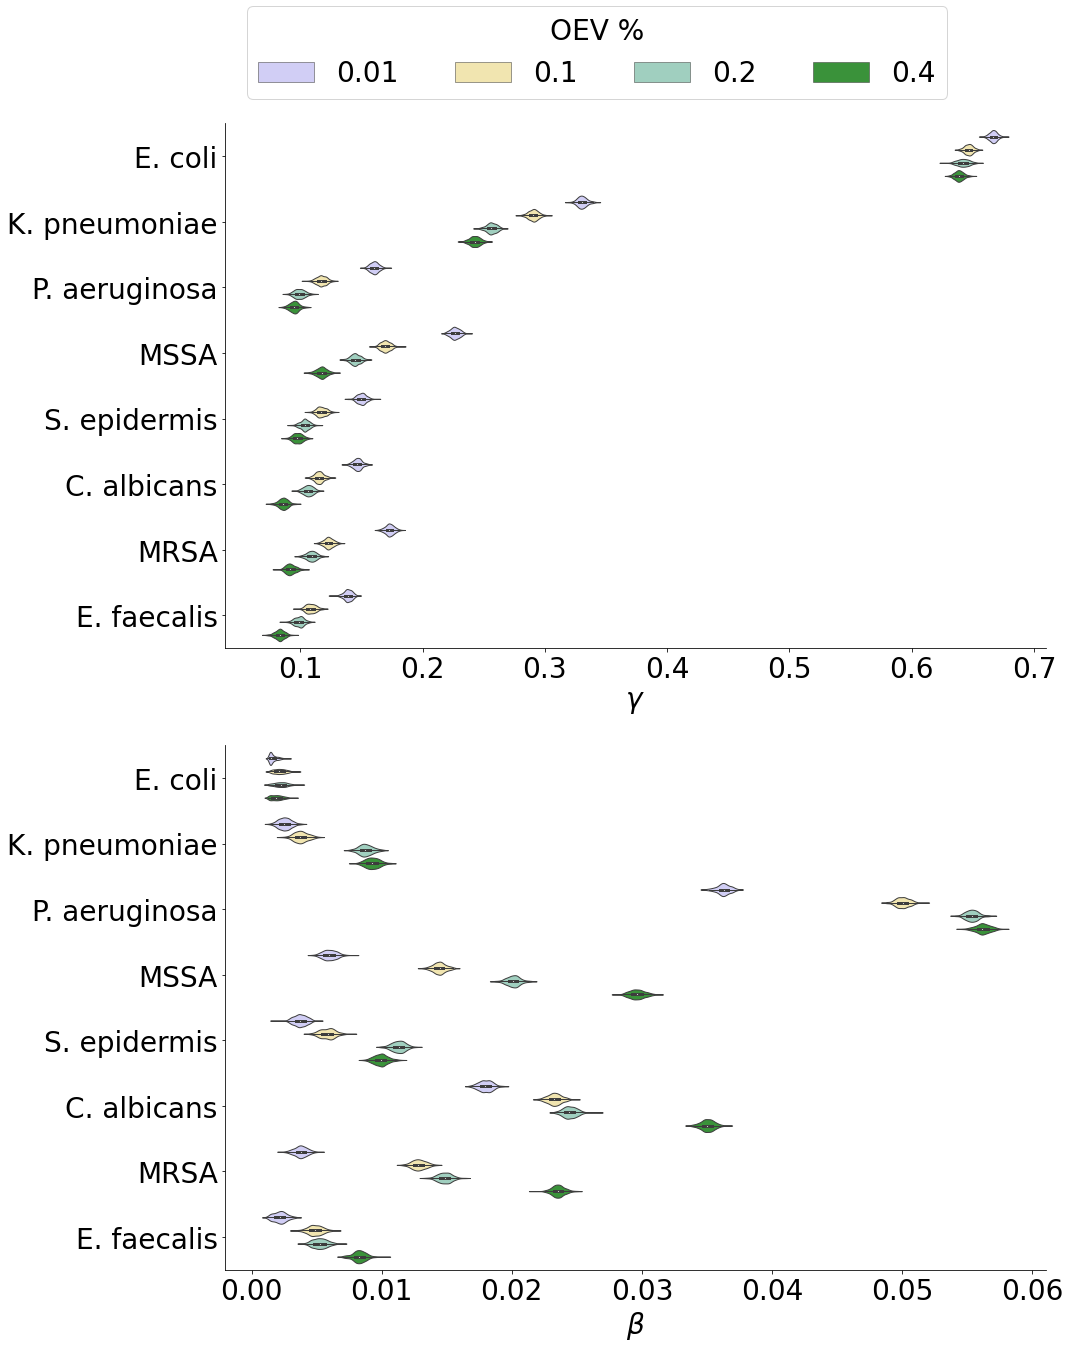

In [18]:
import seaborn as sns

#fig, ax = plt.subplots(2, 1, figsize=(16.5,  12.2), sharey=True)
fig, ax = plt.subplots(2, 1, figsize=(15.5, 19.2), sharey=True, sharex=False)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
colors3_1 = ["#CBC7FC", "#FCECA5", "#98D7C2", "#2ca02c"]

sns.violinplot(ax=ax[0], data=posterior_df, x="gamma", y="organism", hue="oev", palette=colors3_1, linewidth=1, edgecolor="k", alpha=0.5)
sns.violinplot(ax=ax[1], data=posterior_df, x="beta",  y="organism", hue="oev", palette=colors3_1, linewidth=1, edgecolor="k", alpha=0.5)

#sns.scatterplot(ax=ax[0], data=posterior_df.groupby("organism").mean().reset_index(), x="gamma", y="organism", s=150, facecolor="red", edgecolor="k", marker="o", label="Truth", lw=20)
#sns.scatterplot(ax=ax[1], data=posterior_df.groupby("organism").mean().reset_index(), x="beta", y="organism",  s=150, facecolor="red", edgecolor="k", marker="o", label="Truth",  lw=20)

ax[0].legend(title="OEV %", loc="upper left", ncol=4, bbox_to_anchor=[0.01, 1.25])
ax[1].legend().remove()

ax[0].set_ylabel(None)
ax[1].set_ylabel(None)

ax[0].set_xlabel(r"$\gamma$")
ax[1].set_xlabel(r"$\beta$")

sns.despine(right=True, top=True)
plt.tight_layout()

path_to_save_fig  = os.path.join(os.path.join(paper_dir, "paper_01", "SupplementaryFigures"), "SensitivityOEV.png")
fig.savefig(path_to_save_fig, dpi=300, transparent=True)
